In [1]:
from __future__ import annotations

import operator
from typing import TypedDict, List, Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [3]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]

In [4]:
class State(TypedDict):
    topic: str
    plan: Plan
    # reducer: results from workers get concatenated automatically
    sections: Annotated[List[str], operator.add]
    final: str

In [5]:
llm = ChatOpenAI(model="gpt-4.1-mini")

In [6]:
def orchestrator(state: State) -> dict: #Take a topic → create a structured plan → hand that plan to workers.

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    "Create a blog plan with 5-7 sections on the following topic."
                )
            ),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )
    return {"plan": plan}

In [7]:
def fanout(state: State):
    return [
        Send(
            "worker", 
                {
                 "task": task, 
                 "topic": state["topic"], 
                 "plan": state["plan"]
                }
            )
            for task in state["plan"].tasks
            ]

In [8]:
def worker(payload: dict) -> dict:

    # payload contains what we sent
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}

In [ ]:
from pathlib import Path
import re
def reducer(state: State) -> dict:
    
    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    # ---- save to file ----
    filename = title.lower().replace(" ", "_") + ".md"
    # safe_title = re.sub(r"[^\w\s-]", "", title)  # remove special characters
    # filename = safe_title.lower().replace(" ", "_") + ".md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")

    return {"final": final_md}


In [10]:
g = StateGraph(State)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)

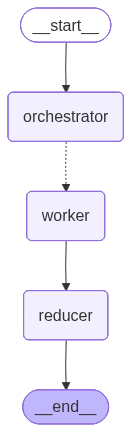

In [11]:
g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

app

# The orchestrator creates a plan with multiple tasks.

# We don’t know how many tasks there will be until runtime.

# So we can’t connect a fixed edge to just one worker.

# The conditional edge calls fanout(state) at runtime, which returns one Send per task.

# LangGraph then runs all these worker nodes in parallel.

# ✅ In short: Conditional edge = “decide how many workers to run, based on the plan the orchestrator made.”

In [18]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})


In [19]:
out

{'topic': 'Write a blog on Self Attention',
 'plan': Plan(blog_title='Understanding Self-Attention: The Heart of Modern Neural Networks', tasks=[Task(id=1, title='Introduction to Self-Attention', brief='Explain the concept of attention in neural networks and introduce self-attention as a mechanism that allows models to weigh the importance of different parts of input data.'), Task(id=2, title='The Mechanics of Self-Attention', brief='Detail how self-attention works step-by-step, including the concepts of queries, keys, and values, and how attention scores are computed and applied.'), Task(id=3, title='Self-Attention in Transformer Models', brief='Discuss the role of self-attention in Transformer architectures, highlighting how it enables efficient handling of sequence data without recurrent structures.'), Task(id=4, title='Advantages of Self-Attention', brief='Explore benefits such as parallelizability, capturing long-range dependencies, and flexibility compared to traditional RNNs or 